In [1]:
import graph_tool.all as gt
import pandas as pd
import numpy as np



### A new approach to pandas integration to graph_tool

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
def draw(graph, is_cell_vert, is_junction_edge):
    not_junction = is_junction_edge.copy()
    not_junction.a = 1 - is_junction_edge.a
    gt.graph_draw(graph, pos_vp, inline=True,
                  vertex_fill_color=is_cell_vert,
                  edge_color=not_junction,
                  output_size=(300, 300))

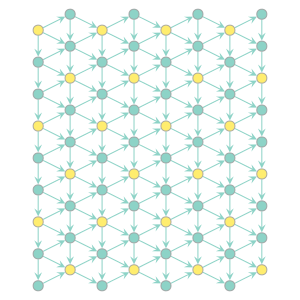

In [4]:
def base_grid(n_cells_x, n_cells_y,
              delta_x=1, delta_y=1):

    n_x = n_cells_x
    n_y = n_cells_y * 3

    xy_grid = np.mgrid[:n_x, :n_y]

    xs = xy_grid[0].astype('float')
    ys = xy_grid[1].astype('float')

    ys[::2, ...] += 0.5
    is_cell_vert = np.zeros_like(xy_grid[1]).astype(np.bool)
    is_cell_vert[::2, ::3] = 1
    is_cell_vert[1::2, 2::3] = 1
    is_cell_vert = is_cell_vert.flatten()

    pos = np.zeros((n_x * n_y, 2))
    pos[:, 0] = xs.flatten() * delta_x
    pos[:, 1] = ys.flatten() * delta_y

    return pos, is_cell_vert






pos, _is_cell_vert = base_grid(8, 3)

graph, pos_vp = gt.geometric_graph(pos, 1.415)
graph.set_directed(True)

is_cell_vert = graph.new_vertex_property('bool')
is_cell_vert.a = _is_cell_vert

is_junction_edge = graph.new_edge_property('bool')
graph.edge_properties['is_junction_edge'] = is_junction_edge
graph.vertex_properties['is_cell_vert'] = is_cell_vert

draw(graph, is_cell_vert, is_junction_edge)


Flipping 0 edges


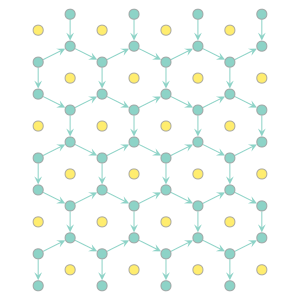

In [6]:
def reorient_edges(graph, is_cell_vert, is_junction_edge):

    to_flip = []
    for edge in graph.edges():
        srce, trgt = edge
        if is_cell_vert[srce] and not is_cell_vert[trgt]:
            is_junction_edge[edge] = 0
        elif not is_cell_vert[srce] and is_cell_vert[trgt]:
            ### Flip the edge
            to_flip.append(edge)
        elif is_cell_vert[srce] and is_cell_vert[trgt]:
            raise ValueError(
                'Invalid cell to cell edge {}'.format(edge))
        else:
            is_junction_edge[edge] = 1

    print('Flipping {} edges'.format(len(to_flip)))
    for edge in to_flip:
        new = graph.add_edge(edge.target(), edge.source())
        is_junction_edge[new] = 0
        graph.remove_edge(edge)
    
reorient_edges(graph, is_cell_vert, is_junction_edge)
graph.set_edge_filter(is_junction_edge)
draw(graph, is_cell_vert, is_junction_edge)
graph.set_edge_filter(None)


In [7]:
def get_faces(graph, as_array=True):
    '''
    Retrieves all the triangular subgraphs of the form

       1 -- > 2
        ^   ^
         \ /
          0

    In our context, vertex 0 always corresponds to a cell
    and vertices 1 and 2 to junction vertices

    Parameters
    ----------

    graph : a :class:`GraphTool` graph instance
    as_array: bool, optional, default `True`
      if `True`, the output of `subraph_isomorphism` is converted
      to a (N, 3) ndarray.

    Returns
    -------

    triangles: (N_t, 3) ndarray
      each line corresponds to a triplet (cell, jv0, jv1)
      where cell, jv0 and jv1 are indices of the input graph
      
      if as_array is False, returns instead the template triangle 3-graph
      and a list of ProperyMaps as returned by `gt.subgraph_isomorphism`
      
    '''
    tri_graph = gt.Graph()
    ## the vertices
    verts = tri_graph.add_vertex(3)
    ## edges
    tri_graph.add_edge_list([(0, 1), (0, 2), (1, 2)])
    _triangles = gt.subgraph_isomorphism(tri_graph, graph)
    if not as_array:
        return tri_graph, _triangles
    triangles = np.array([tri.a for tri in _triangles], dtype=np.int)
    return triangles


In [8]:
triangles = get_faces(graph)

In [9]:
triangles[:5]

array([[ 0,  1, 10],
       [ 0,  9, 10],
       [ 3,  2, 12],
       [ 3,  4, 13],
       [ 3, 12, 13]])

In [10]:
face_data = {
    ## Normal
    'ux': (0., np.float),
    'uy': (0., np.float),
    'uz': (0., np.float)}

names =('cell', 'jv_i', 'jv_j')
letters = ('a', 'i', 'j')
tix_aij = pd.MultiIndex.from_arrays(triangles.T,
                                    names=names)
faces = pd.DataFrame(index=tix_aij,
                     columns=face_data.keys())


In [12]:
faces.head(10)

uy   uz   ux
cell jv_i jv_j               
0    1    10    NaN  NaN  NaN
     9    10    NaN  NaN  NaN
3    2    12    NaN  NaN  NaN
     4    13    NaN  NaN  NaN
     12   13    NaN  NaN  NaN
6    5    15    NaN  NaN  NaN
     7    16    NaN  NaN  NaN
     15   16    NaN  NaN  NaN
11   1    2     NaN  NaN  NaN
          10    NaN  NaN  NaN

In [267]:
cells = gt.GraphView(graph, vfilt=is_cell_vert)

In [268]:
cells.vertex_properties['is_cell_vert']

<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f572b992518, at 0x7f572b992550, with values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]>

In [269]:
class FacesView:
    '''constructor class to get and set
    data on the columns of a dataframe with repeated values
    for each vertex or edge of the graph'''
    def __init__(self, graph, faces_idx, name, key_type):
        self.name = name
        self.graph = graph # Can be a GraphView
        self._idx = faces_idx
        self.key_type = key_type
                
    def __getitem__(self, prop_name):
        
        if self.key_type == 'v':
            prop = graph.vp[prop_name]
        elif self.key_type == 'e':
            prop = graph.vp[prop_name]
        return pd.Series(prop.a[self._idx],
                         index=self._idx, name=self.name)

    def __setitem__(self, prop_name, data):
        
        if self.key_type == 'v':
            prop = graph.vp[prop_name]
        elif self.key_type == 'e':
            prop = graph.vp[prop_name]
        prop.fa = data
        
def test_faces_view(graph, faces_idx, name):
    
    
    fview = FacesView(graph, faces_idx, name, 'v')
    prop = graph.new_vertex_property('long', 0)
    graph.vertex_properties['test'] = prop
    view = fview['test']
    repeats = np.bincount(fview._idx)
    assert view.shape[0] == repeats.sum()
    
    r0 = repeats[0]
    v0 = graph.vertex(fview._idx[0])
    prop[v0] = 100
    #view = fview['test']
    np.testing.assert_array_equal(fview['test'].iloc[:repeats[0]],
                                  np.ones(repeats[0]) * 100)
    
    fview['test'] = np.ones(repeats.sum(), dtype=np.int)
    
    assert prop[v0] == 1
    


In [270]:
test_faces_view(graph, cell_idx, 'cell')

In [271]:
cells_view = FacesView(graph, faces.index.get_level_values('cell'), 'cell', 'v')

In [203]:
print(cells_view['is_cell_vert'].shape)
%timeit cells_view['is_cell_vert']
%timeit cells_view['is_cell_vert'] = np.zeros(112)

(112,)
10000 loops, best of 3: 126 µs per loop


In [272]:
graph.set_vertex_filter(is_cell_vert)
print(pos_vp.get_2d_array([0, 1]).shape)
graph.set_vertex_filter(None)

(2, 72)


In [273]:
pos_vp.set_2d_array?

In [257]:
graph.vertex_properties['is_cell_vert'] = is_cell_vert
cells = gt.GraphView(graph, vfilt=is_cell_vert)

In [245]:
x, y = gt.ungroup_vector_property(pos_vp, [0, 1])

In [259]:
graph.vp['is_cell_vert']

<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f572b9bebe0, at 0x7f572b995a20, with values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]>

In [247]:
y

<PropertyMap object with key type 'Vertex' and value type 'double', for Graph 0x7f572b9bebe0, at 0x7f5729f9d940, with values:
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  0.   1.   2.   3.   4.   5.
  6.   7.   8.   0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  0.   1.   2.
  3.   4.   5.   6.   7.   8.   0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5
  0.   1.   2.   3.   4.   5.   6.   7.   8.   0.5  1.5  2.5  3.5  4.5  5.5
  6.5  7.5  8.5  0.   1.   2.   3.   4.   5.   6.   7.   8. ]>

In [238]:
cells_view['pos']

ValueError: Cannot get array for value type: vector<double>

> /home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/__init__.py(516)get_array()
    515         if a is None:
--> 516             raise ValueError("Cannot get array for value type: " + self.value_type())
    517         return PropertyArray(a, prop_map=self)

ipdb> c


In [ ]:
class Triangles:
    '''
    Data structure defined to index the ensembles of sub-graph homologue to
    this topology:

     jv_i (i) -- > (j) jv_j
           ^       ^
            \     /
             \   /
              (a) cell

    In the 3D coordinate system, this represents an oriented
    triangular face.  Note that as long as the cell to junction edges
    go outward from the cell, the complete epithelium is a unique
    set of faces homologue to this topology (regardess of the
    orientation of jv_i and jv_j) thus the triangle is the unit element
    of the geometrical network - in the cristalography sense of unit
    element.

    '''

    def __init__(self, triangles,
                 vertex_df=None,
                 edge_df=None,):
        '''
        Creates a container class for the triangles geometry

        Parameters
        ----------

        triangles: ndarray
          trianges is a (N_t, 3) 2D array where each line contains
          a triple with the indices of the cell, the source (jv_i)
          and the target (jv_j) junction vertices.
        vertex_df:  :class:`pandas.DataFrame` table
          This data frame should contain the vertices data. It is indexed by the
          vertices indices in the graph.
        edge_df:  :class:`pandas.DataFrame` table
          DataFrame with the edges data. It is indexed by a
          :class:`pandas.MultiIndex` object indexed by
          (source, target) pairs.

        See Also
        --------

        hdfgraph.graph_to_dataframes: utility to convert a graph_tool.Graph
          to a dataframe pairs
        leg_joint.topology.get_faces: utility to obtain  the triangles list
          from a graph

        '''
        if vertex_df is not None:
            self.vertex_df = vertex_df
            self.edge_df = edge_df
        self.triangles_array = triangles
        self.coords = ['x', 'y', 'z']
        self.dcoords = ['d'+c for c in self.coords]
        self.normal_coords = ['u'+c for c in self.coords]

        self._build_indices(triangles)
        self.faces = pd.DataFrame(index=self.tix_aij,
                                  columns=face_data.keys())
        self.grad_array = pd.DataFrame(index=self.uix_active,
                                       columns=self.coords)
        self.grad_array[:] = 0

    def copy(self):
        return Triangles(self.triangles_array.copy(),
                         self.vertex_df.copy(),
                         self.edge_df.copy())

    def _build_indices(self, faces):

        self.indices = {}
        names =('cell', 'jv_i', 'jv_j')
        letters = ('a', 'i', 'j')

        self.uix_active = self.vertex_df[
            self.vertex_df.is_active_vert==1].index

        ### MultiIndex named (cell, jv_i, jv_j) for each triangle
        ### Those indices must be coherent with the original graph
        self.tix_aij = pd.MultiIndex.from_arrays(faces.T,
                                                 names=names)
        self.indices[tuple(names)] = self.tix_aij
        for letter, name  in zip(letters, names):

            ### single level index on current
            ### vertex type (contains repeated values)
            idx_name = 'tix_{}'.format(letter)
            idx = self.tix_aij.get_level_values(name)
            setattr(self, idx_name, idx)
            self.indices[name] = idx

            view_name = 'tdf_{}'.format(name)
            dv = DataView(self.vertex_df, idx)
            setattr(self, view_name, dv)

            unique = idx.unique()
            unique_name = 'uix_{}'.format(letter)
            setattr(self, unique_name, unique)

            view_name = 'udf_{}'.format(name)
            dv = DataView(self.vertex_df, unique)
            setattr(self, view_name, dv)

            ### 2 level MultiIndex on the oriented edge opposed
            ### to the current vertex
            other_letters = list(letters)
            other_letters.remove(letter)
            other_names = list(names)
            other_names.remove(name)

            idx_name = 'tix_{}{}'.format(*other_letters)
            idx = self.tix_aij.droplevel(name)
            setattr(self, idx_name, idx)
            view_name = 'tdf_{}to{}'.format(*other_letters)
            dv = DataView(self.edge_df, idx)
            setattr(self, view_name, dv)

            self.indices[tuple(other_names)] = idx
            unique_name = 'uix_{}{}'.format(*other_letters)
            unique = idx.unique()
            setattr(self, unique_name, unique)
            view_name = 'udf_{}to{}'.format(*other_letters)
            dv = DataView(self.edge_df, unique)
            setattr(self, view_name, dv)

        self.uix_active_i = np.array(
            list(set(self.uix_active).intersection(self.uix_i)))
        self.uix_active_j = np.array(
            list(set(self.uix_active).intersection(self.uix_j)))
